# Generate COCO formatted JSON 
This tutorial is about how to generate the annotation descriptions into COCO formatted json file. 

In [1]:
import os 
import sys 
sys.path.append("./trainer/")
print(sys.path)

['C:\\Users\\camin\\PhD_DB\\CV2020-project_iMaterialist', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\python37.zip', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\DLLs', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\lib', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env', '', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\lib\\site-packages', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\lib\\site-packages\\win32', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\lib\\site-packages\\win32\\lib', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\lib\\site-packages\\Pythonwin', 'C:\\Users\\camin\\anaconda3\\envs\\pytorch_env\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\camin\\.ipython', './trainer/']


In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

import torchvision
from torchvision import datasets, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.optim.lr_scheduler import MultiStepLR

In [3]:
from PIL import Image, ImageFile
import numpy as np 
import pandas as pd 
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

In [4]:
a = np.array([9])
print(type(a))

<class 'numpy.ndarray'>


In [5]:
from DataLoader import Fashion2020dataset

In [6]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
df_csv   = Path("../imaterialist-fashion-2020-fgvc7/train.csv")

Dataloader = Fashion2020dataset(root= data_dir, transforms=None, csv_path=df_csv)

In [7]:
Dataloader.root

WindowsPath('../imaterialist-fashion-2020-fgvc7')

In [8]:
Dataloader.img_lists

['00000663ed1ff0c4e0132b9b9ac53f6e.jpg',
 '0000fe7c9191fba733c8a69cfaf962b7.jpg',
 '0002ec21ddb8477e98b2cbb87ea2e269.jpg',
 '0002f5a0ebc162ecfb73e2c91e3b8f62.jpg',
 '0004467156e47b0eb6de4aa6479cbd15.jpg',
 '00048c3a2fb9c29340473c4cfc06424a.jpg',
 '0006ea84499fd9a06fefbdf47a5eb4c0.jpg',
 '000775b6b5e27b011dc8bba2d7b85211.jpg',
 '000aac3870ea7c59ca0333ffa5327323.jpg',
 '000b3a87508b0fa185fbd53ecbe2e4c6.jpg',
 '000b3ec2c6eaffb491a5abb72c2e3e26.jpg',
 '000c5bb8ca785bce8d00e3a6c7802a8c.jpg',
 '000c9b4926cd78edd4c19cbc6beba111.jpg',
 '000cd2e13d1bdd28f480304d7bb9e1ca.jpg',
 '000e147149bf33c584afaa953bc198ed.jpg',
 '000e18920575a2e59b3a0c38e6546d29.jpg',
 '000e973c99dc090afd7898c93daf0dbc.jpg',
 '00102686c01fa625aba3b2478f48f415.jpg',
 '001039acb67251508b1b32fd37a49f43.jpg',
 '0010ef2da53cd76ee26122a65f6e76ee.jpg',
 '001657dc6f979869ebf38ea741e90675.jpg',
 '0016d83ce041f39f0a5d94382bf96369.jpg',
 '0017a7bb9e2d8a0f44ce040ed164eea6.jpg',
 '0017af9f7fa8ce9e7558bb924cec324e.jpg',
 '001a66b16b12f1

In [9]:
Dataloader.__len__()

45623

### 객체 슬라이싱과 ```__getitem__```
* [refer to](https://jinmay.github.io/2019/11/26/python/python-instance-slice/)

In [10]:
#img, target = Dataloader.__getitem__(15)
img, target = Dataloader[0]

Image loading: 00000663ed1ff0c4e0132b9b9ac53f6e


In [11]:
img_lists = list(sorted(os.listdir(os.path.join(data_dir, "train"))))
file_name = target["image_id"]

print(target["image_id"])
print(f"File name is: {file_name}.jpg")

00000663ed1ff0c4e0132b9b9ac53f6e
File name is: 00000663ed1ff0c4e0132b9b9ac53f6e.jpg


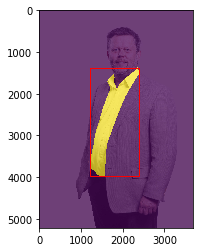

In [12]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

%matplotlib inline 
idx = 1      # _ change the number withing range 
xmin, ymin, xmax, ymax = target["boxes"][idx]

plt.imshow(img)
plt.imshow(target["masks"][idx], alpha=0.7)

plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin  , ymax-ymin, linewidth=1,edgecolor='r',facecolor='none'))

***

# Data Preparation for Training 
* We got a total of 45623 training RGB images. 
* Data should be splited into the training and validation set. 
* We need data in the COCO JSON format. 

In [13]:
# _Start: split data into train and validation in a 9:1 ratio
def split_train_validation(data_lists:list):
    img_lists = data_lists
    #print(img_files)
    train_idx = [] 
    val_idx   = [] 
    
    # _Start: split 
    for i, img_file in enumerate(img_lists): 
#    for i, img_file in enumerate(range(80)): 
        if i % 10 == 0: 
            val_idx.append(i)
        else:
            train_idx.append(i)    
    # _End: split 
    
    print(f"Number of training samples: {len(train_idx)}")
    print(f"Number of validation samples: {len(val_idx)}")
    
    return train_idx, val_idx
# _End: split data into train and validation in a 9:1 ratio


train_idx, val_idx = split_train_validation(Dataloader.img_lists)

Number of training samples: 41060
Number of validation samples: 4563


### Generate COCO formatted JSON 
* [COCO formated json doc](http://cocodataset.org/#format-data)

In [14]:
import json
import pandas as pd
label_ds_json = os.path.join(data_dir, 'label_descriptions.json')


# _Start: get label descriptions from json 
with open(label_ds_json, 'r') as file:
    label_desc = json.load(file)
# _End: get label descriptions  from json 


# _Start: Classes and Attributes processing 
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])
# _End: Classes and Attributes processing 

In [15]:
df_categories["name"][0]

'shirt, blouse'

In [16]:
df_categories

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [21]:
import cv2

def get_contour_pts(mask_img):
    mask = mask_img

    assert mask is not None, "mask is empty..."

    ret, thresh = cv2.threshold(mask, 127, 255,  0)

    _, orig_contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
        
    sorted_contours = [] 
    cnt_area = [] 

    for cnt in orig_contours:
        if len(cnt.shape) == 3 and cnt.shape[1] == 1:
            cnt_area.append(cv2.contourArea(cnt))
            sorted_contours.append(cnt.reshape(-1).tolist())

    contour = [p for p in sorted_contours if len(p) > 4]
    area = [cnt_area[i] for i, p in enumerate(sorted_contours) if len(p)>4]

    return (contour, area)

cnt, area = get_contour_pts(target["masks"][0].numpy())


In [22]:
import json

def generate_COCO_formatted_json(Dataloader:Fashion2020dataset, data_idx:list ,json_filepath:str):
    annotations = []
    images = []
    categories = []
    
    for i, idx in tqdm(enumerate(data_idx), desc="JSON processing..."):
        img, target = Dataloader[idx]
        
        image_filename = '{}.jpg'.format(target["image_id"])

        if len(img.shape) == 3:
            w,h, _ = img.shape
        else:
            w,h = img.shape 
        
        if image_filename not in Dataloader.img_lists:
            continue 
            
        
        for i, mask in enumerate(target["masks"]):
            
            contour, area = get_contour_pts(mask.numpy())
            
            if not contour:
                continue 
                
            xmin, ymin, xmax, ymax = target["boxes"][i] 
            annotations.append({"segmentation": contour,
                                "iscrowd": 0, 
                                "image_id": target["image_id"],
                                "bbox": [xmin, ymin, xmax-xmin, ymax-ymin],
                                "area": area[0],
                                "category_id": target["class_ids"][i],
                                "id": target["image_id"] + str(i) })
            
            categories.append({"supercategory":df_categories["supercategory"][target["class_ids"][i]] ,
                               "id":target["class_ids"][i],
                               "name": df_categories["name"][target["class_ids"][i]]    })
            
        
        images.append({"file_name" : image_filename,
                       "height": h,
                       "width" : w,
                       "id" : target["image_id"]  })
            

    with open(json_filepath, "w") as f:
        json.dump({"images": images, "annotations": annotations, "categories": categories}, f)
        
    return

In [ ]:
train_json_path = os.path.join(data_dir, 'train.json')
validation_json_path = os.path.join(data_dir, 'validation.json')


# Get train.json in coco format 
#generate_COCO_formatted_json(Dataloader= Dataloader,
#                             data_idx= train_idx,
#                             json_filepath=train_json_path )


# Get validation.json in coco format 
generate_COCO_formatted_json(Dataloader=Dataloader,
                             data_idx= val_idx,
                             json_filepath=validation_json_path)

JSON processing...: 0it [00:00, ?it/s]

Image loading: 00000663ed1ff0c4e0132b9b9ac53f6e


JSON processing...: 1it [00:14, 14.94s/it]

Image loading: 000b3ec2c6eaffb491a5abb72c2e3e26


JSON processing...: 2it [00:17, 11.22s/it]

Image loading: 001657dc6f979869ebf38ea741e90675


JSON processing...: 3it [00:18,  8.16s/it]

Image loading: 00213526750c326a6d8cac9d44b458de


JSON processing...: 4it [00:18,  5.81s/it]

Image loading: 0038d87bdf966bc82cf430f924c1d8c6


JSON processing...: 5it [00:21,  4.90s/it]

Image loading: 0040e5863c5e6197cd264509bc2fbb1c


JSON processing...: 6it [00:27,  5.21s/it]

Image loading: 004dc465c15bb89f419f4e528468ef57


JSON processing...: 7it [00:29,  4.09s/it]

Image loading: 0056447a613cceb08686906bdfa512a2


JSON processing...: 8it [00:29,  3.00s/it]

Image loading: 006588bfc246a67c7d3afdf5201a26d2


JSON processing...: 9it [00:29,  2.25s/it]

Image loading: 006e38304fa87bcfd82b6101c478730c


JSON processing...: 10it [00:30,  1.74s/it]

Image loading: 008324a52c5910d338807fb785ebaa0a


JSON processing...: 11it [00:31,  1.39s/it]

Image loading: 00916e59d76e64984243a397f06a329f


JSON processing...: 12it [00:34,  2.06s/it]

Image loading: 00a36421366d8a6b61921d8b4b2e615d


JSON processing...: 13it [00:35,  1.69s/it]

Image loading: 00b54cabb88bcf014b7d30f0a3988fce


JSON processing...: 14it [00:37,  1.64s/it]

Image loading: 00bfc94340e552180ce0efb8a2024eff


JSON processing...: 15it [00:37,  1.21s/it]

Image loading: 00cd5bb501e031aeeeeb337fb3f5b6d8


JSON processing...: 16it [00:37,  1.02s/it]

Image loading: 00dede1486489c56683a011283ffce62


JSON processing...: 17it [00:51,  4.94s/it]

Image loading: 00ebd9bce869b275ab358f6702e73f30


JSON processing...: 19it [01:02,  4.56s/it]

Image loading: 00f8f5f0ed311b44eb6654091001b655
Image loading: 010f48755074bf05eb0247c9faf414ae


JSON processing...: 20it [01:02,  3.25s/it]

Image loading: 011b63573f6d2e7ea6eaaca179dae44d


JSON processing...: 21it [01:02,  2.37s/it]

Image loading: 01246de18d07137e90be7c960d00714b


JSON processing...: 22it [01:03,  1.85s/it]

Image loading: 01330309bf64b598e7fa1abd21a3807d


JSON processing...: 23it [01:07,  2.72s/it]

Image loading: 013cd3aa60ac339c913d3df17cc53eb8


JSON processing...: 24it [01:24,  6.73s/it]

Image loading: 014f39c986fde2fa1d052b00e59045a7


JSON processing...: 25it [01:25,  5.01s/it]

Image loading: 0166a1390e55a7b18efe4d85f1d99777


JSON processing...: 26it [01:37,  7.18s/it]

Image loading: 016def9cce72d98977bafc15cda73497


JSON processing...: 27it [01:38,  5.38s/it]

Image loading: 017d0e0aa2b32962980eed824e5a1850


JSON processing...: 28it [02:14, 14.52s/it]

Image loading: 019243e533a88acfc5d5f2a4da725656


JSON processing...: 29it [02:14, 10.28s/it]

Image loading: 019cac91e7586f6dfd6a2b8e79cabcad


JSON processing...: 30it [02:19,  8.57s/it]

Image loading: 01a94dc56674f8f72fe08cc8f3331621


JSON processing...: 31it [02:22,  6.84s/it]

Image loading: 01ba043e720dabf925412da94e8a08ef


JSON processing...: 32it [02:22,  4.90s/it]

Image loading: 01ce6c4ee5cd53d8bc824e0aab53559d


JSON processing...: 33it [02:22,  3.53s/it]

Image loading: 01de41d210af9428235a33ba42312636


JSON processing...: 34it [02:23,  2.61s/it]

Image loading: 01ec1705a5dad92febd7a336c4bb9dda
Image loading: 01f674e727ee420fd0e2c9a0be8c9c9b


JSON processing...: 36it [02:24,  2.00s/it]

Image loading: 02049fbb94cc90e8aac8a7b206f84563


JSON processing...: 37it [02:26,  2.08s/it]

Image loading: 021af4001512419103e1b00d2d743878


JSON processing...: 38it [02:27,  1.61s/it]

Image loading: 022a380b568cbb515f30933e984590c6


JSON processing...: 39it [02:31,  2.44s/it]

Image loading: 023029080799112bd67f82ae88a0c9ab


JSON processing...: 40it [02:47,  6.55s/it]

Image loading: 023bf396d37a20ce41648130fa173f2e


JSON processing...: 41it [02:48,  4.69s/it]

Image loading: 0248ac2a108ee8c57c5ad931631ef886


JSON processing...: 42it [02:48,  3.45s/it]

Image loading: 025200ad487f2930aaf09e04c18f2f12


JSON processing...: 43it [02:50,  2.89s/it]

Image loading: 025eea6cc05fd843b617b9ef44dc55fb


JSON processing...: 44it [02:52,  2.58s/it]

Image loading: 026f81f30d9ec9ba6944322bebd8a471


JSON processing...: 45it [02:52,  1.91s/it]

Image loading: 027c0ad5eca53fc2570012428623b0f9


JSON processing...: 46it [03:01,  4.16s/it]

Image loading: 0289181e16fefe3136ce48ffe59a88a5


JSON processing...: 47it [03:04,  3.83s/it]

Image loading: 0297cbadc47c133a601c4815a3a25ec3


JSON processing...: 48it [03:16,  6.08s/it]

Image loading: 02aa4b46ee9084230858d5a987df5de1


JSON processing...: 50it [03:16,  3.10s/it]

Image loading: 02bd43e1b0f372db269e6366b27f692c
Image loading: 02c654835d3300441b2b15117578dfda


JSON processing...: 51it [03:17,  2.40s/it]

Image loading: 02d37d3dbb43790542416ca05f648a77


JSON processing...: 52it [03:19,  2.42s/it]

Image loading: 02dda109ad70d552d715cf60f217fbc1


JSON processing...: 53it [03:24,  3.01s/it]

Image loading: 02f2544ee18bff535a2c535f23a51166


JSON processing...: 54it [03:25,  2.44s/it]

Image loading: 02faeaad81ada834b7145d19ad76c24b


JSON processing...: 55it [03:26,  1.87s/it]

Image loading: 030907e5b49ce359ab768cf0ec33e6fb


JSON processing...: 56it [03:30,  2.70s/it]

Image loading: 031ccca5e1b18f5257fb1693713dcda3


JSON processing...: 57it [03:37,  3.90s/it]

Image loading: 03297a99b3e25a02e953dec20c45f668


JSON processing...: 58it [03:40,  3.57s/it]

Image loading: 0335a1942e83438b3a7b3f1fe0783b9c


JSON processing...: 59it [03:42,  3.27s/it]

Image loading: 03430afdd3e5a3398224cbe3e10c5a33


JSON processing...: 60it [03:46,  3.49s/it]

Image loading: 0358083441aa2db7a73eed8577606b78


JSON processing...: 61it [03:47,  2.72s/it]

Image loading: 0366a1d50ecfe35aea85a432683f0952


JSON processing...: 62it [03:48,  2.04s/it]

Image loading: 036fa2f658e6c35fd3503734404dd045


JSON processing...: 63it [03:48,  1.51s/it]

Image loading: 037a5ae6d642325e5f80690253caf74d


JSON processing...: 64it [03:51,  1.94s/it]

Image loading: 0381f81cf1a29ac07f6fe467df7380d9


JSON processing...: 65it [03:54,  2.24s/it]

Image loading: 0395d0c75e6eeecc16173c0015841101


JSON processing...: 66it [03:54,  1.72s/it]

Image loading: 039ed9ff9bd57bf9717e798ff3598f7e


JSON processing...: 67it [03:55,  1.37s/it]

Image loading: 03b2d8d1968f300e5c4038a5e200dba3


JSON processing...: 68it [04:02,  3.22s/it]

Image loading: 03c0f79b356cef281b24d62c6798485a


JSON processing...: 69it [04:13,  5.44s/it]

Image loading: 03cf565cf7c9ec746d7b3f76cb2ae0d8


JSON processing...: 70it [04:14,  4.00s/it]

Image loading: 03db8de410b85a2af9abc770c96875bc


JSON processing...: 71it [04:15,  3.10s/it]

Image loading: 03ebb3b4c195415126834c89f8da55b5


JSON processing...: 72it [04:19,  3.47s/it]

Image loading: 03f6b6a7a3501293398165b879b1f32e


JSON processing...: 74it [04:42,  6.53s/it]

Image loading: 040a02dbcc9fd9a870eaa8259db8015b
Image loading: 04158562ca8454db0fa64d4eb4409c9c


JSON processing...: 75it [04:42,  4.70s/it]

Image loading: 0426a5f4256dec87908e8e97de7aa4c7


JSON processing...: 76it [04:43,  3.51s/it]

Image loading: 0442cb8999e7afde63d85e97b46ad6b5


JSON processing...: 77it [04:44,  2.61s/it]

Image loading: 044c02b64364099930e7a953c1b4927f


JSON processing...: 78it [04:45,  2.28s/it]

Image loading: 045ae2713508a9560ae2c808bbfbd798


JSON processing...: 79it [04:53,  3.84s/it]

Image loading: 0461935888bad18244f11e67e7d3b417


JSON processing...: 80it [04:54,  3.21s/it]

Image loading: 0473a75fd1b459821692a563d1a1398c


JSON processing...: 81it [04:55,  2.54s/it]

Image loading: 0485e3a4bdc877e2930c42338c63459f


JSON processing...: 82it [05:00,  3.11s/it]

Image loading: 04902e6413764119ddbda8f774646f8b


JSON processing...: 83it [05:03,  3.23s/it]

Image loading: 049da7a199dc0fb19b1bb0bb97054e5e


JSON processing...: 84it [05:04,  2.47s/it]

Image loading: 04af99e5cf1ae417eb34de2994bad43c


JSON processing...: 85it [05:05,  2.07s/it]

Image loading: 04bf90ad2bd23d1f9cf213862b8cf5be


JSON processing...: 86it [05:12,  3.41s/it]

Image loading: 04d1f22e2ea0076e63a42b1e2b69928f


JSON processing...: 87it [05:13,  2.84s/it]

Image loading: 04de26fbf467aad7175cfa5b820690e1


JSON processing...: 88it [05:15,  2.61s/it]

Image loading: 04ef0b1b6a5d27a86d29e3424476d31d


JSON processing...: 89it [05:18,  2.53s/it]

Image loading: 04f68105df909a0ca3344aca597a7b34


JSON processing...: 90it [05:18,  1.90s/it]

Image loading: 05066a615dd5fb32b255f8f5df40f0ca


JSON processing...: 91it [05:20,  2.02s/it]

Image loading: 051304baf10af948afc409fed4e15be3


JSON processing...: 92it [05:20,  1.48s/it]

Image loading: 05293339021b1d238aefbcff65d61f6c


JSON processing...: 93it [05:22,  1.36s/it]

Image loading: 05387c86c7009b0dfb5f38fa1ee0d9af


## COCO Image Viewer 
* [refer to](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#create-custom-coco-dataset)

In [11]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np 
import cv2 
import random 
import os 
import json 
import matplotlib.pyplot as plt 

In [12]:
from detectron2.utils.visualizer import Visualizer, ColorMode

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

### Register Dataset

In [14]:
train_data_name = 'fashion_train'
val_data_name = 'fashion_val'

train_json_path = os.path.join(data_dir, 'train.json')

register_coco_instances(train_data_name, {}, train_json_path, os.path.join(data_dir, 'train') )
register_coco_instances(val_data_name, {}, validation_json_path, os.path.join(data_dir, 'validation') )

### Visualize Training Data

[05/31 14:27:26 d2.data.datasets.coco]: Loading ../imaterialist-fashion-2020-fgvc7/train.json takes 18.43 seconds.
WARNING [05/31 14:27:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 14:27:26 d2.data.datasets.coco]: Loaded 41060 images in COCO format from ../imaterialist-fashion-2020-fgvc7/train.json


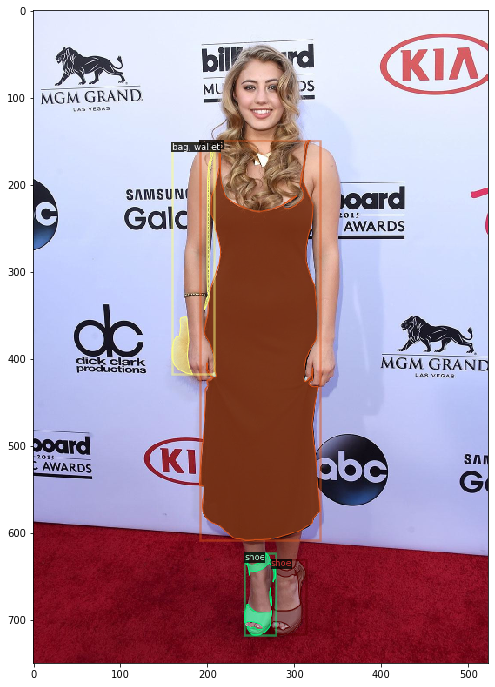

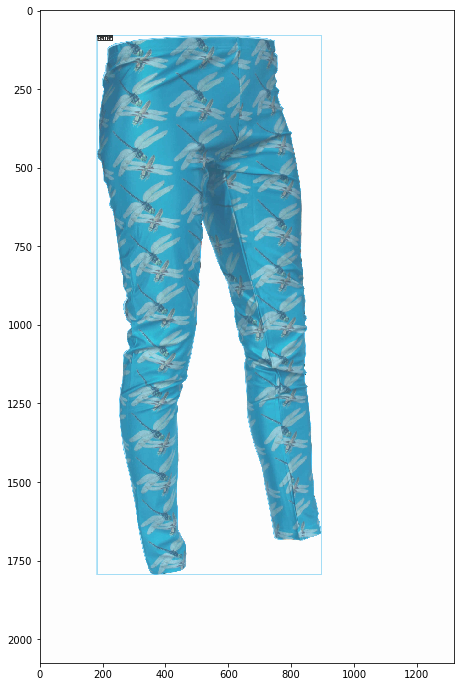

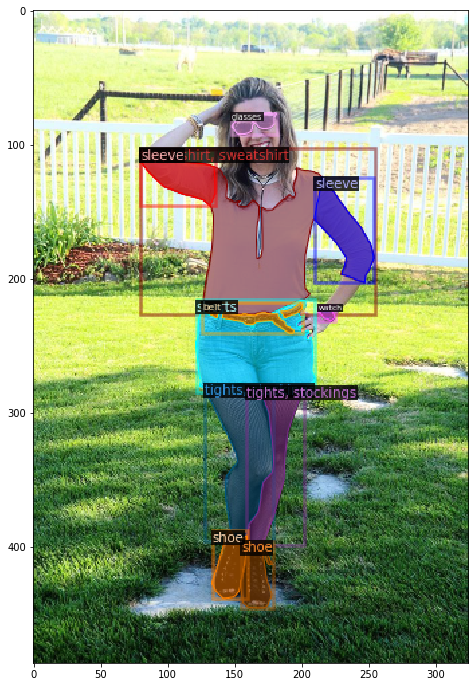

In [18]:
backpack_train_metadata = MetadataCatalog.get(train_data_name)

dataset_dicts = DatasetCatalog.get(name=train_data_name)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=backpack_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()